In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bot.config.settings import Settings
from bot.core.encoder import TextEncoder
from bot.data.dataset import DatasetManager
from bot.model.utils import read_best_params
from sklearn.model_selection import (StratifiedKFold, cross_val_score, cross_val_predict, train_test_split)
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [2]:
encoder = TextEncoder(Settings.MODEL_CLS)
root = Path().cwd().parent
dm = DatasetManager(path=root / "data/data.csv")
X, y = encoder.encode(dm.get_X()), np.where(dm.get_y() == 0, -1, 1)
X_tain, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=Settings.RNG_INT, shuffle=True, stratify=y)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=Settings.RNG_INT)

In [3]:
best_params = read_best_params(root / "bot/model/optunalogs/linear_svc_1743772017.json")
clf = LinearSVC(**best_params, max_iter=10_000, random_state=Settings.RNG_INT)

In [4]:
f1_scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')
recall_scores = cross_val_score(clf, X, y, cv=cv, scoring='recall')
precision_scores = cross_val_score(clf, X, y, cv=cv, scoring='precision')

print(f"f1: {f1_scores.mean()} +/- {f1_scores.std()}")
print(f"recall: {recall_scores.mean()} +/- {recall_scores.std()}")
print(f"precision: {precision_scores.mean()} +/- {precision_scores.std()}")

f1: 0.9735479797979799 +/- 0.024159504786172896
recall: 0.965032679738562 +/- 0.03883392611831052
precision: 0.9839181286549709 +/- 0.034030113581176885


In [5]:
def threshold_cross_validation(estimator, X, y, thresholds, cv=5):
    y_scores = cross_val_predict(estimator, X, y, cv=cv, method="predict_proba")[:, 1]
    results = []
    for thresh in thresholds:
        y_pred = np.where((y_scores >= thresh).astype(int) == 0, -1, 1)
        precision = precision_score(y, y_pred, zero_division=0)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        results.append({
            "Threshold": thresh,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        })
    return pd.DataFrame(results)

In [6]:
results_df = threshold_cross_validation(
    CalibratedClassifierCV(clf, method="sigmoid", cv=cv, ensemble=True, n_jobs=5), 
    X, y,
    thresholds=np.linspace(0.4, 0.95, 12),
    cv=cv
)

In [7]:
results_df

,Threshold,Precision,Recall,F1
0,0.40,0.970930,0.965318,0.968116
1,0.45,0.976608,0.965318,0.970930
2,0.50,0.982353,0.965318,0.973761
3,0.55,0.981928,0.942197,0.961652
4,0.60,0.981481,0.919075,0.949254
5,0.65,0.987261,0.895954,0.939394
6,0.70,0.993506,0.884393,0.935780
7,0.75,0.993333,0.861272,0.922601
8,0.80,0.993056,0.826590,0.902208
9,0.85,1.000000,0.768786,0.869281


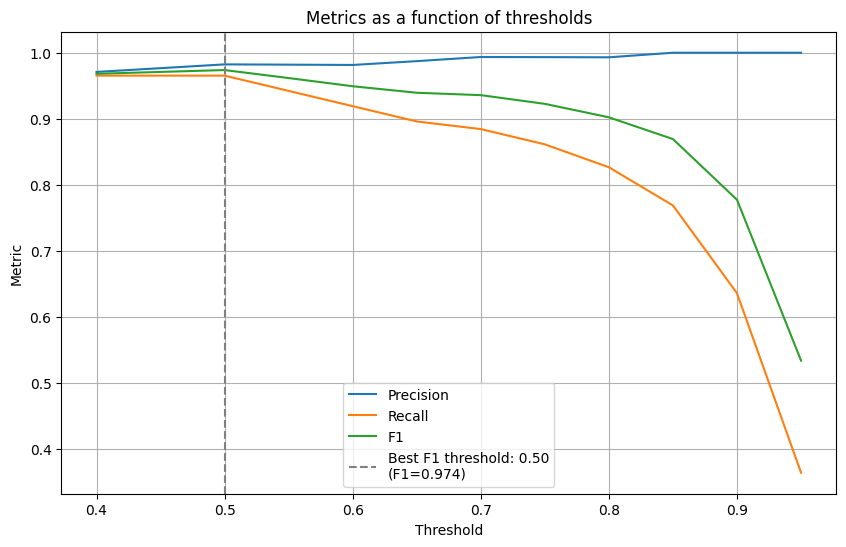

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["F1"], label="F1")
    
best_idx = results_df["F1"].idxmax()
best_thresh = results_df.loc[best_idx, "Threshold"]
best_f1 = results_df.loc[best_idx, "F1"]
    
plt.axvline(x=best_thresh, color="gray", linestyle="--", label=f"Best F1 threshold: {best_thresh:.2f}\n(F1={best_f1:.3f})")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title("Metrics as a function of thresholds")
plt.legend()
plt.grid(True)
plt.show()